Instruction for TA: We have two files. 

* one of them includes our custom nerual network model and the Resnet18 model.
* other one includes our final model which is a Resnet50 Model.



ResNet50 - Final Model

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
New working directory: /content/gdrive/MyDrive
(60000, 1, 28, 28)


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 199MB/s]


Epoch 1/50, Training Loss: 1.7042417205969493, Training Accuracy: 0.3954166666666667, Validation Loss: 1.1006776525619182, Validation Accuracy: 0.6118333333333333
Epoch 2/50, Training Loss: 1.0546587102413179, Training Accuracy: 0.6546875, Validation Loss: 0.7248581782617467, Validation Accuracy: 0.76525
Epoch 3/50, Training Loss: 0.7838975577354431, Training Accuracy: 0.7529375, Validation Loss: 0.7128476085180931, Validation Accuracy: 0.8034166666666667
Epoch 4/50, Training Loss: 0.7124873239199321, Training Accuracy: 0.7764791666666667, Validation Loss: 0.5265782167936893, Validation Accuracy: 0.8405833333333333
Epoch 5/50, Training Loss: 0.7918134997685751, Training Accuracy: 0.754, Validation Loss: 0.46466811310420647, Validation Accuracy: 0.8554166666666667
Epoch 6/50, Training Loss: 0.5801789957682292, Training Accuracy: 0.8188541666666667, Validation Loss: 0.3687016722211178, Validation Accuracy: 0.88075
Epoch 7/50, Training Loss: 0.5225958119432131, Training Accuracy: 0.836437

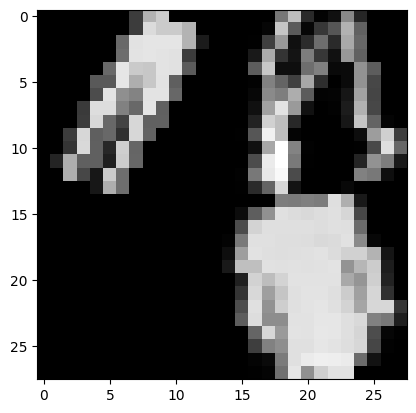

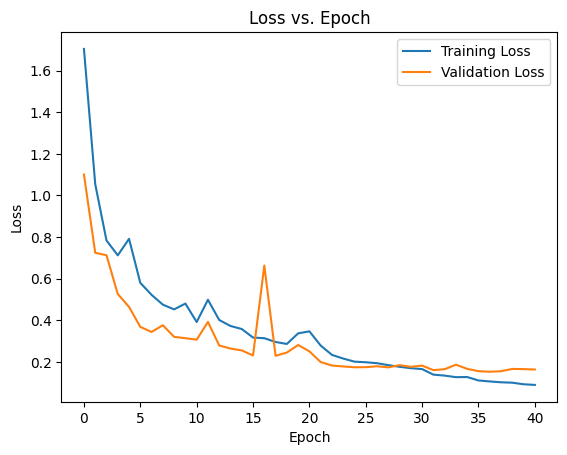

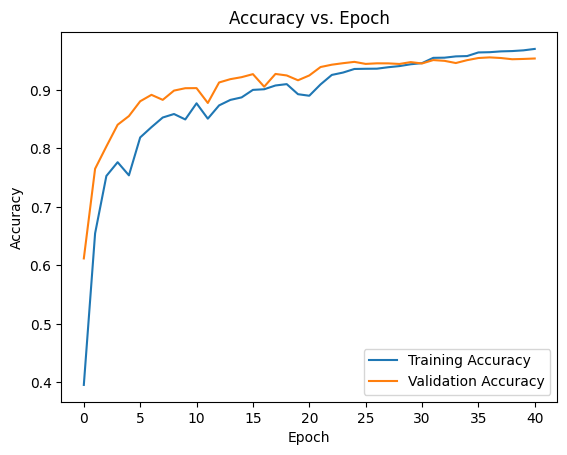

In [5]:
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
import pandas as pd
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt

# load and mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

import os
os.chdir('/content/gdrive/MyDrive')

# Verify that the working directory has been changed
print("New working directory:", os.getcwd())

# Load the training data and labels
train_data = pickle.load(open('./Train.pkl', 'rb'), encoding='bytes')
train_labels = np.genfromtxt('./Train_labels.csv', delimiter=',', skip_header=1)[:, 1].astype(int)

# Convert the training labels to a PyTorch tensor and move to GPU
train_labels = torch.from_numpy(train_labels).long()
train_labels = train_labels.cuda()
# ploting the data set

plt.imshow(train_data[0,:,:].squeeze(),cmap='gray')
print(train_data.shape)

# Split the training data into a training set and a validation set
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

# Define a custom dataset class to load the data
class CustomDataset(Dataset):
    def __init__(self, data, targets=None, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx].reshape(28, 28, 1)
        if self.transform:
            image = self.transform(image)

        if self.targets is not None:
            label = self.targets[idx]
            return image.cuda(), label.cuda()
        else:
            return image.cuda()

# Data augmentation Part: Define the data transformations for the training and validation sets*
transform_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_val = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create custom dataset instances for the training and validation sets
train_dataset = CustomDataset(train_data, train_labels, transform_train)
val_dataset = CustomDataset(val_data, val_labels, transform_val)

# Define the batch size* played with this parameter to find proper one*
batch_size = 64

# Create data loaders for the training and validation sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)



# Loading the ResNet-50 model and modify the last layer to output 10 classes*
model = models.resnet50(pretrained=True)

# Unfreeze all layers for fine-tuning*** Fine-tune the model: Instead of only training the last layer, fine-tune the entire network by unfreezing some or all of the layers. This allows the model to learn features specific to your dataset. 
#for param in model.parameters():
   # param.requires_grad = True

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.cuda()

# Define the loss function and optimizer** using 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the learning rate scheduler*
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# Set the number of epochs and the early stopping patience*
num_epochs = 50
best_val_loss = float('inf')
epochs_without_improvement = 0
patience = 4

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Set the model to training mode
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    # Loop over the training data in batches*
    for images, labels in train_loader:
         # Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        # Calculate the training loss and accuracy
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)
# Set the model to evaluation mode
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    # Loop over the validation data in batches
    with torch.no_grad():
        for images, labels in val_loader:
          # Make predictions
            outputs = model(images)
            loss = criterion(outputs, labels)
            # Calculate the validation loss and accuracy
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)
# Calculate the average validation loss and accuracy*
    val_loss /= len(val_loader)
    scheduler.step(val_loss)

    train_accuracy = train_correct / train_total
    val_accuracy = val_correct / val_total

    train_losses.append(train_loss / len(train_loader))
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
# early stopping*
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement == patience:
        print("Early stopping triggered")
        break

    print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_loss / len(train_loader)}, Training Accuracy: {train_accuracy}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

# Plotting loss
plt.figure()
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss vs. Epoch")
plt.show()

# Plotting accuracy
plt.figure()
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy vs. Epoch")
plt.show()

transform_test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_data = pickle.load(open('./Test.pkl', 'rb'), encoding='bytes')
test_dataset = CustomDataset(test_data, transform=transform_test)

# Create a data loader for the test data
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Load the saved best model and make predictions on the test data
model.eval()
predictions = []

with torch.no_grad():
    for images in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        if torch.cuda.is_available():
            predicted = predicted.cpu()
        predictions.extend(predicted.numpy())

predictions = np.array(predictions)

submission_df = pd.DataFrame({'id': list(range(0, len(predictions))), 'class': predictions})
submission_df.to_csv('ExampleSubmission.csv', index=False, header=['id', 'class'])
